# NBAPositionify: Leveraging Data Mining Techniques to Classify Professional Basketball Players into Positions

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
## Get Dataset from Kaggle
# Requires the kaggle package to download dataset. Uncomment the line below to install
# !pip3 install kaggle
import kaggle
# Requires kaggle.json (Kaggle API Key) placed in ~/.kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files("drgilermo/nba-players-stats", path="./data/", unzip=True)

## Exploratory Data Analysis

Our data is from `basketball-reference.com`. Three datasets:

In [3]:
player_data = pd.read_csv("./data/player_data.csv")
player_data.head(1)


,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University


In [4]:
players = pd.read_csv("./data/Players.csv")
players.head(1)

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN


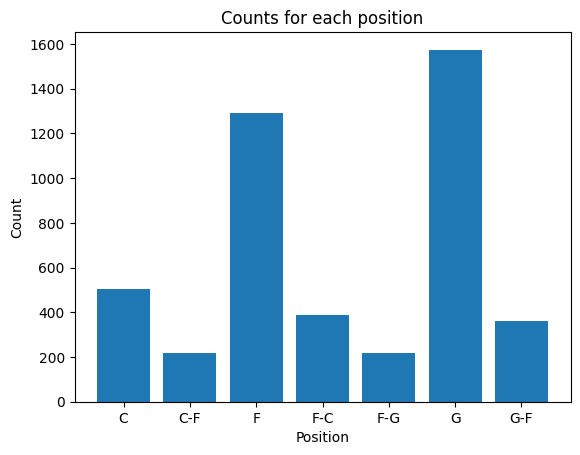

In [5]:
plt.bar(player_data.groupby('position').size().index, player_data.groupby('position').size().values)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Counts for each position')
plt.show()

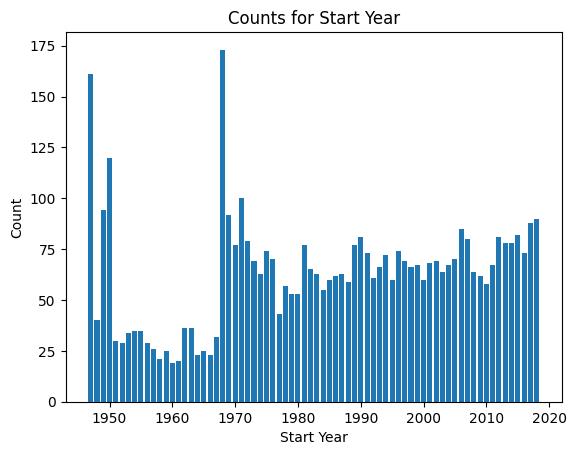

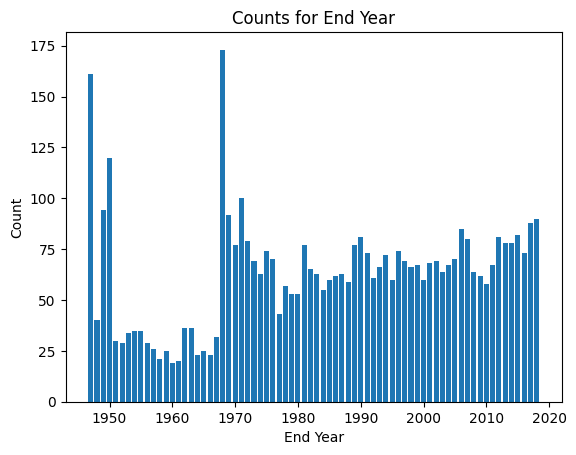

In [6]:
plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Counts for Start Year')
plt.show()

plt.bar(player_data.groupby('year_start').size().index, player_data.groupby('year_start').size().values)
plt.xlabel('End Year')
plt.ylabel('Count')
plt.title('Counts for End Year')
plt.show()

In [7]:
stats = pd.read_csv("season_stats_preprocessed.csv")

# Clustering

## Data Normalization

In [8]:
def normalize_data(data):
    return (data-data.mean())/data.std()

## KMeans Clustering

In [9]:
from sklearn.cluster import KMeans

def kmeans(n_clusters, normalize=False, columns=["height_inches", "AST%", "weight", "TRB%"]):
    kmeans_stats = stats[columns]
    if normalize:
        kmeans_stats = normalize_data(kmeans_stats)
    model = KMeans(n_clusters=n_clusters)
    model.fit(kmeans_stats)

    kmeans_stats["cluster"] = model.labels_
    kmeans_stats.insert(0, "Pos", stats["Pos"])
    return kmeans_stats, model.inertia_

## Agglomerative Clustering (Hierarchical Approach)

In [10]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative(n_clusters, normalize=False, columns=["height_inches", "AST%", "weight", "TRB%"]):
    agglomerative_stats = stats[columns]
    if normalize:
        agglomerative_stats = normalize_data(agglomerative_stats)
    model = AgglomerativeClustering(n_clusters=n_clusters)
    results = model.fit_predict(agglomerative_stats)

    agglomerative_stats["cluster"] = model.labels_
    agglomerative_stats.insert(0, "Pos", stats["Pos"])

    return agglomerative_stats

## Visualization Generators

In [11]:
def bar_chart_clusters(data, n_clusters):
    for cluster in range(n_clusters):
        cur = data.loc[data["cluster"] == cluster]
        plt.bar(cur.groupby('Pos').size().index, cur.groupby('Pos').size().values)
        plt.xlabel('Position')
        plt.ylabel('Count')
        plt.title(f'Counts for each position in cluster {cluster}')
        plt.show()

In [12]:
def pie_chart_clusters(data, n_clusters):
    for cluster in range(n_clusters):
        cur = data.loc[data["cluster"] == cluster]
        position_percentages = (cur['Pos'].value_counts() / len(cur)).sort_values(ascending=False)
        plt.pie(cur['Pos'].value_counts())
        plt.title(f"Distribution of players by position in cluster {cluster}")
        plt.axis("equal")
        legend_labels = [f"{position}: {round(percentage, 3)}%" for position, percentage in zip(position_percentages.index, position_percentages.values)]
        plt.legend(legend_labels, loc="best")
        plt.show()

In [13]:
def scatter_plot_clusters(data, n_clusters, x, y, i=-1):
    if i != -1:
        plt.subplot(2, 2, i)
    cluster_colors = ['red', 'orange', 'green', 'blue', 'purple']
    for cluster in range(n_clusters):
        cluster_data = data.loc[data["cluster"] == cluster]
        cluster_data = stats.loc[cluster_data.index.values]
        label = f"Cluster {cluster}"
        plt.scatter(cluster_data[x], cluster_data[y], color=cluster_colors[cluster], label=label, alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Cluster Analysis based on {x} and {y}')
    plt.legend()
    plt.grid(True)
    if i == -1:
        plt.show()

In [14]:
def plot_clusters_and_wcss(cluster_arr, wcss_arr):
    plt.plot(cluster_arr, wcss_arr, marker='o', linestyle='-')
    plt.title('Within-Cluster Sum of Squares for 1-5 Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.grid(True)
    plt.xticks(cluster_arr)
    plt.show()

## KMeans Clustering

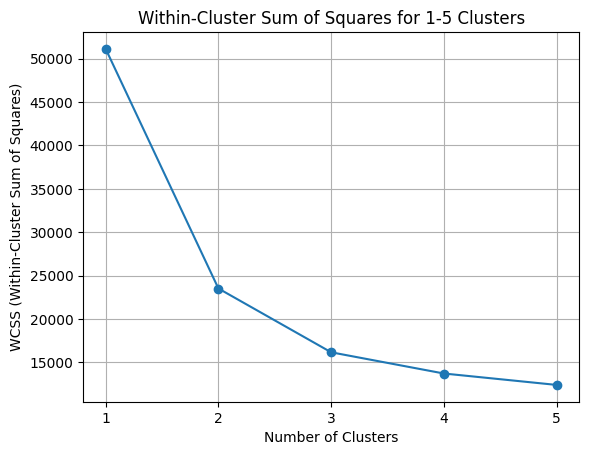

Optimal KMeans Clustering Cluster Amount: 5


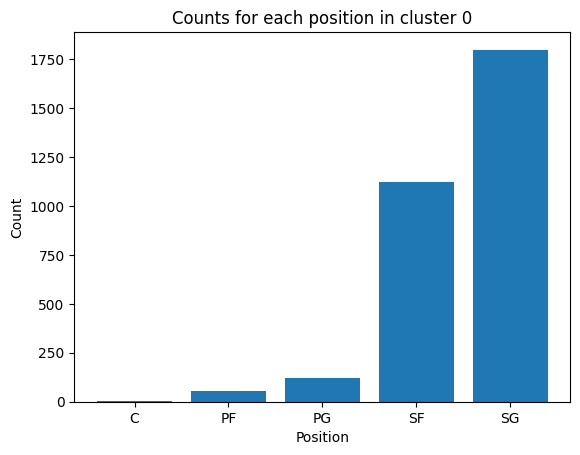

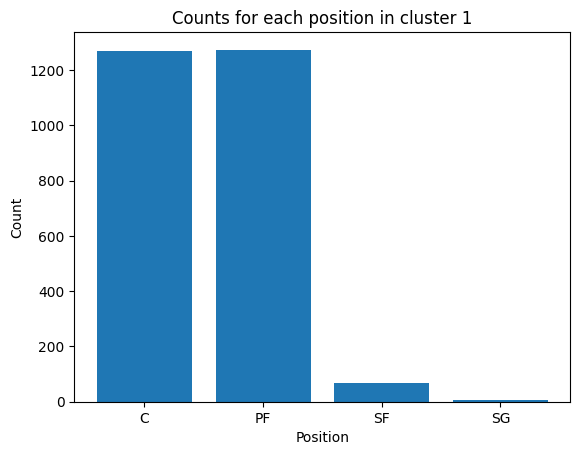

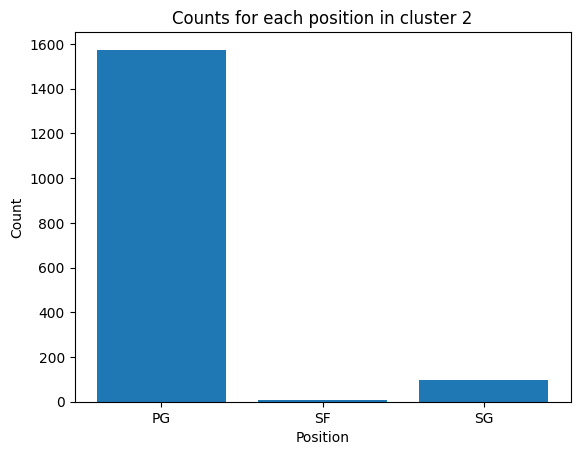

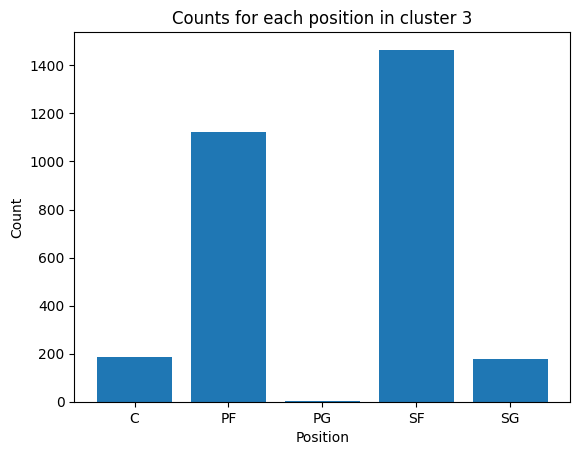

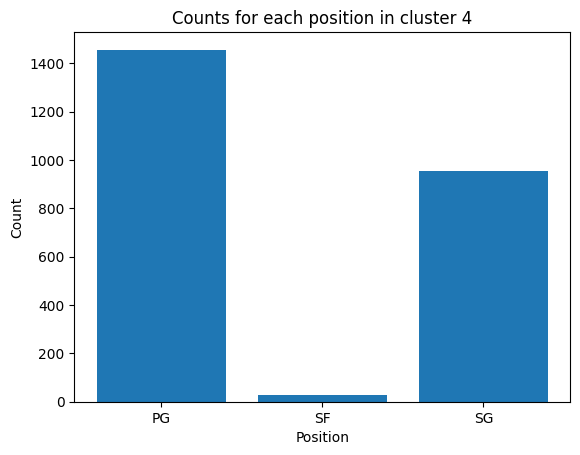

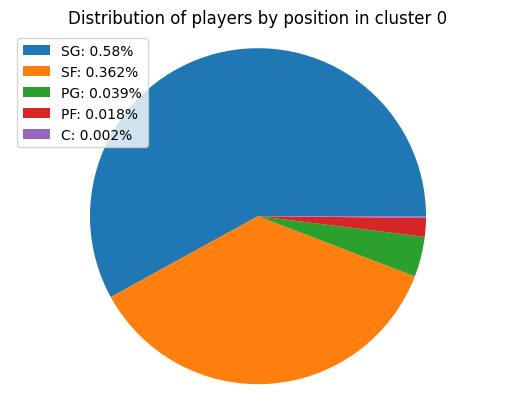

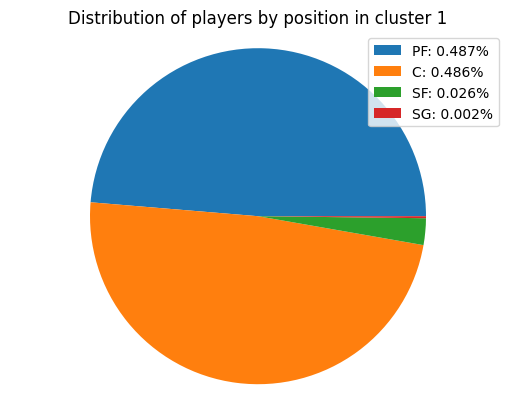

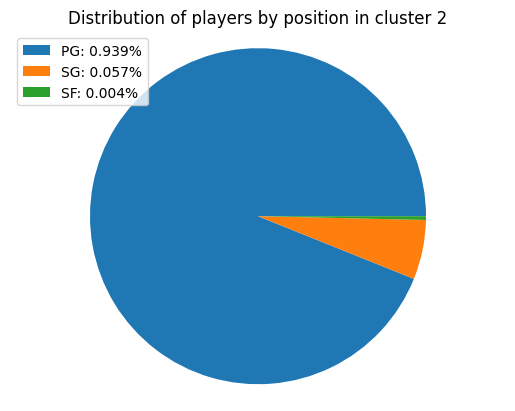

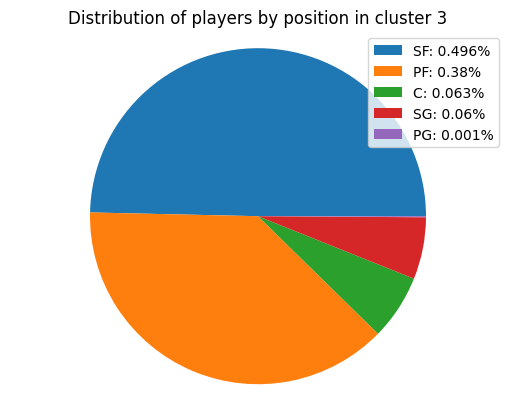

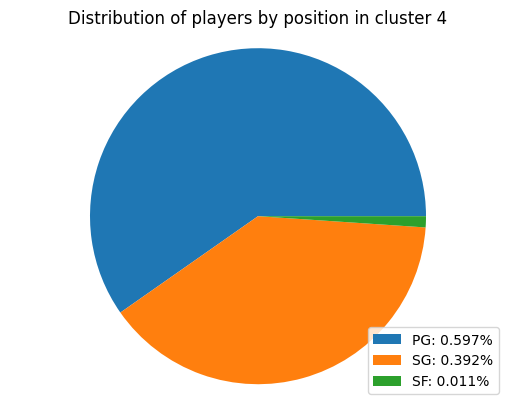

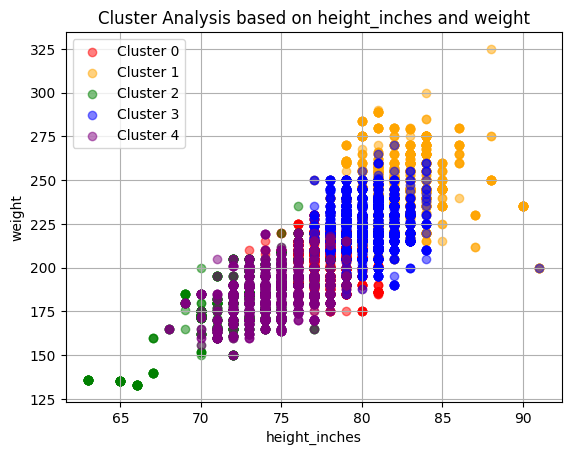

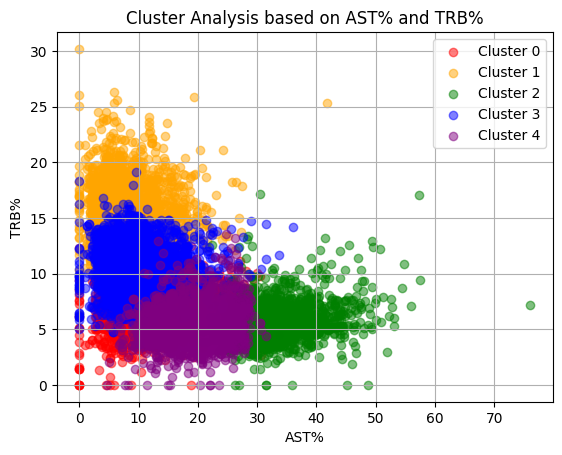

In [15]:
wcss_arr = []
cluster_arr = []
stats_arr = []
for cluster_count in range(1, 6):
    kmeans_stats, wcss = kmeans(cluster_count, True)
    wcss_arr.append(wcss)
    cluster_arr.append(cluster_count)
    stats_arr.append(kmeans_stats)
min_wcss = min(wcss_arr)
min_clusters = cluster_arr[wcss_arr.index(min_wcss)]
kmeans_opt_stats = stats_arr[wcss_arr.index(min_wcss)]
plot_clusters_and_wcss(cluster_arr, wcss_arr)
print("Optimal KMeans Clustering Cluster Amount:", min_clusters)
bar_chart_clusters(kmeans_opt_stats, min_clusters)
pie_chart_clusters(kmeans_opt_stats, min_clusters)
scatter_plot_clusters(kmeans_opt_stats, min_clusters, 'height_inches', 'weight')
scatter_plot_clusters(kmeans_opt_stats, min_clusters, 'AST%', 'TRB%')
plt.show()

## Agglomerative Clustering

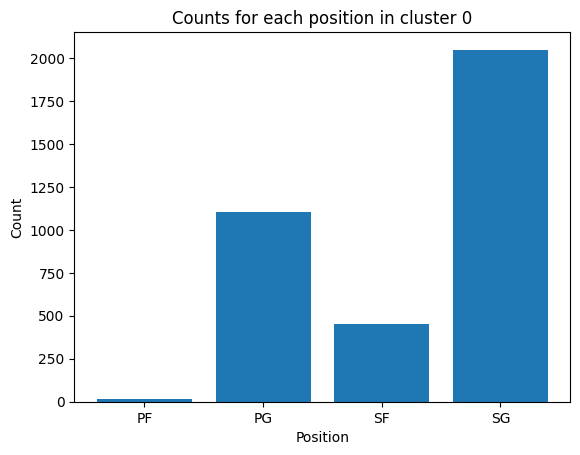

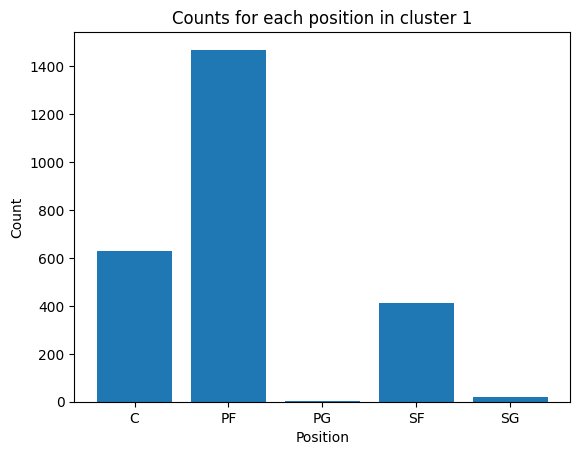

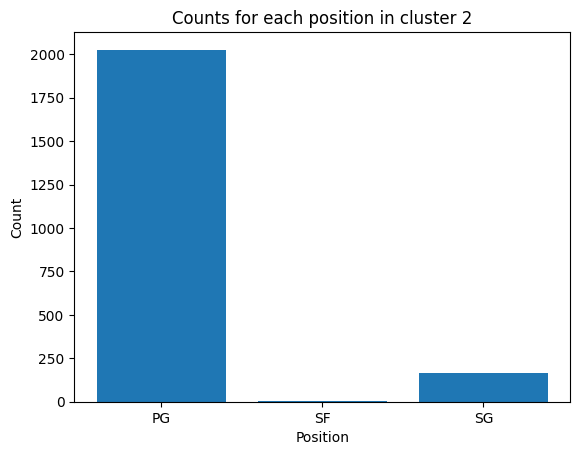

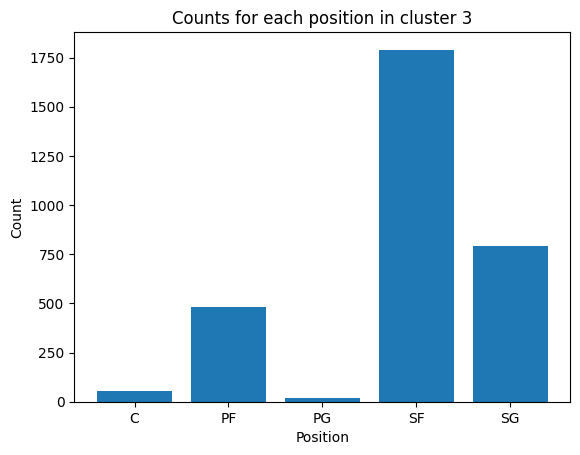

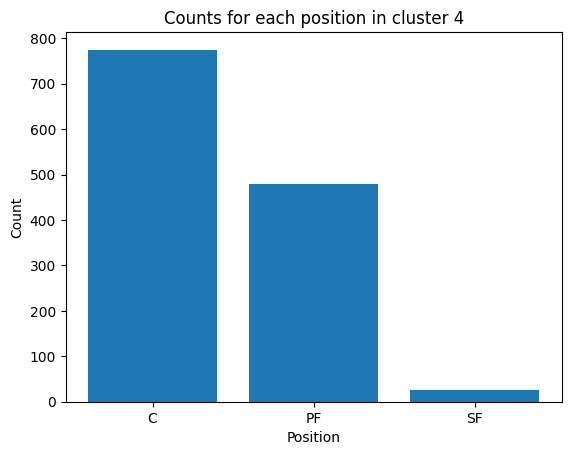

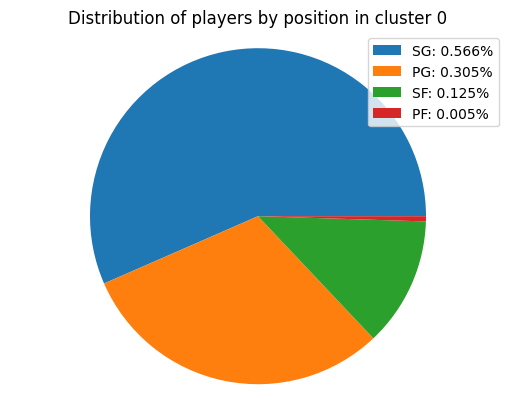

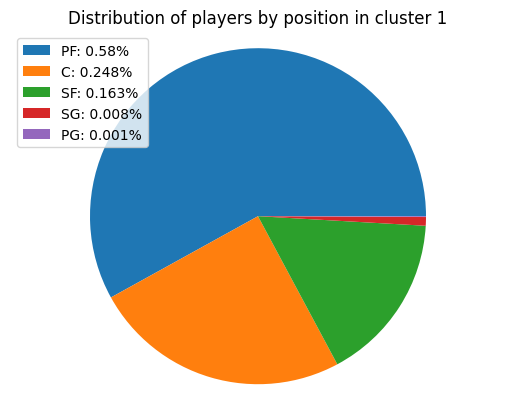

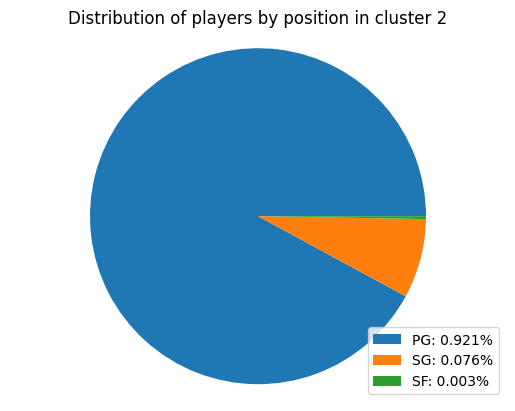

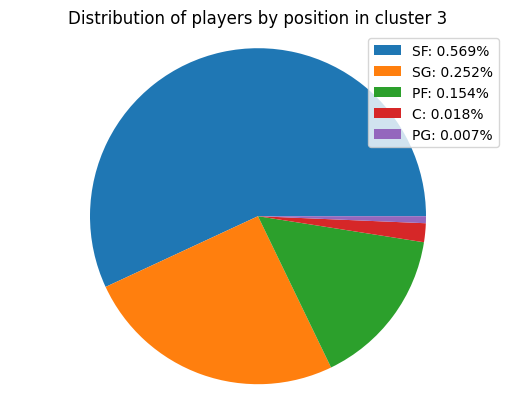

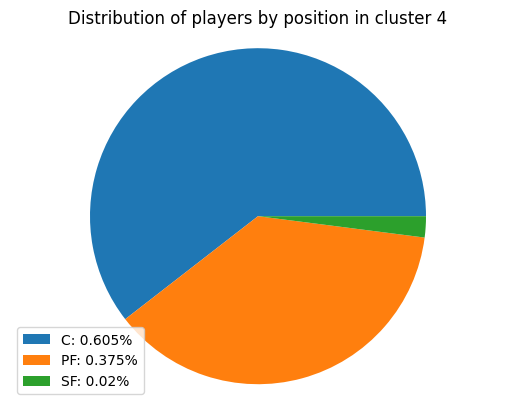

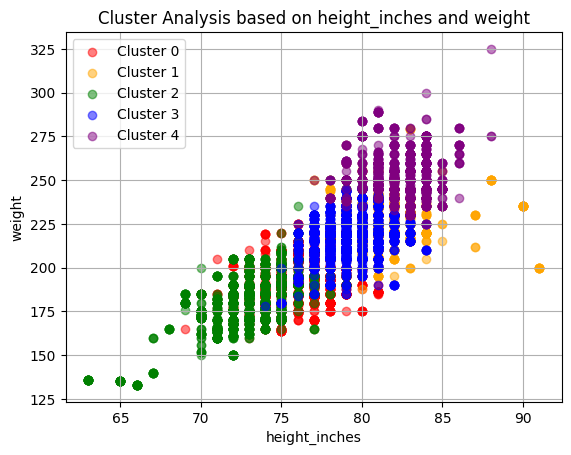

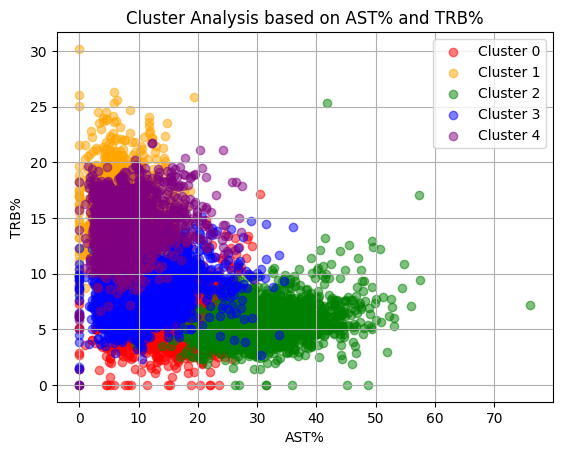

In [16]:
agglomerative_stats_norm = agglomerative(min_clusters, True)
bar_chart_clusters(agglomerative_stats_norm, min_clusters)
pie_chart_clusters(agglomerative_stats_norm, min_clusters)
scatter_plot_clusters(agglomerative_stats_norm, min_clusters, 'height_inches', 'weight')
scatter_plot_clusters(agglomerative_stats_norm, min_clusters, 'AST%', 'TRB%')

# Outlier Analysis - From Clustering

Visual observation of the counts from clusters 1 and 2 shows that cluster 1 contains mostly backcourt players - those playing center or power forward. Similarly, cluster 2 conatins mostly frontcourt players - those playing point guard and shooting guard. As a result, we'll inspect the player info of the rows in those clusters which do not fit within those groups and therefore can be classified as "outliers" in a sense.

### Cluster: SG, Position: PF

In [22]:
cluster_0 = agglomerative_stats_norm.loc[agglomerative_stats_norm["cluster"] == 0]
cluster_0_pf_outliers = cluster_0.loc[cluster_0["Pos"] == "PF"]
stats.loc[cluster_0_pf_outliers.index.values]

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
393,6986,6986,1983.0,Mickey Johnson,PF,30.0,MIL,6.0,0.0,153.0,...,16.0,25.0,11.0,1.0,2.0,12.0,22.0,67.0,82.0,190.0
940,7786,7786,1985.0,Louis Orr,PF,26.0,NYK,79.0,31.0,2452.0,...,220.0,391.0,134.0,100.0,27.0,138.0,195.0,1007.0,80.0,175.0
1248,8224,8224,1986.0,David Thirdkill,PF,25.0,BOS,49.0,0.0,385.0,...,43.0,70.0,15.0,11.0,3.0,19.0,55.0,163.0,79.0,195.0
1379,8427,8427,1987.0,Bill Hanzlik,PF,29.0,DEN,73.0,10.0,1990.0,...,177.0,256.0,280.0,87.0,28.0,132.0,245.0,952.0,79.0,185.0
1709,8868,8868,1988.0,Charles Jones,PF,26.0,POR,37.0,0.0,186.0,...,20.0,31.0,8.0,3.0,6.0,12.0,28.0,51.0,75.0,180.0
1968,9237,9237,1989.0,Harvey Grant,PF,23.0,WSB,71.0,1.0,1193.0,...,88.0,163.0,79.0,35.0,29.0,28.0,147.0,396.0,80.0,195.0
1980,9254,9254,1989.0,Bill Hanzlik,PF,31.0,DEN,41.0,0.0,701.0,...,75.0,93.0,86.0,25.0,5.0,53.0,82.0,201.0,79.0,185.0
1986,9261,9261,1989.0,Rod Higgins,PF,29.0,GSW,81.0,1.0,1887.0,...,265.0,376.0,160.0,39.0,42.0,76.0,172.0,856.0,79.0,200.0
2009,9289,9289,1989.0,Bill Jones,PF,22.0,NJN,37.0,0.0,307.0,...,27.0,47.0,20.0,17.0,6.0,18.0,38.0,129.0,79.0,175.0
2287,9682,9682,1990.0,Harvey Grant,PF,24.0,WSB,81.0,25.0,1846.0,...,204.0,342.0,131.0,52.0,43.0,85.0,194.0,664.0,80.0,195.0


### Cluster: PF, Position: PG

In [21]:
cluster_1 = agglomerative_stats_norm.loc[agglomerative_stats_norm["cluster"] == 1]
cluster_1_pg_outliers = cluster_1.loc[cluster_1["Pos"] == "PG"]
stats.loc[cluster_1_pg_outliers.index.values]

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
5594,14183,14183,1999.0,Sam Jacobson,PG,23.0,LAL,2.0,0.0,12.0,...,3.0,3.0,0.0,0.0,0.0,1.0,2.0,8.0,76.0,215.0
8269,18207,18207,2006.0,Alvin Williams,PG,31.0,TOR,1.0,0.0,10.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,77.0,185.0


### Cluster: PG, Position: SF

In [23]:
cluster_2 = agglomerative_stats_norm.loc[agglomerative_stats_norm["cluster"] == 2]
cluster_2_sf_outliers = cluster_2.loc[cluster_2["Pos"] == "SF"]
stats.loc[cluster_2_sf_outliers.index.values]

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
1213,8181,8181,1986.0,Paul Pressey,SF,27.0,MIL,80.0,80.0,2704.0,...,272.0,399.0,623.0,168.0,71.0,240.0,247.0,1146.0,77.0,185.0
1479,8558,8558,1987.0,Paul Pressey,SF,28.0,MIL,61.0,60.0,2057.0,...,198.0,296.0,441.0,110.0,47.0,186.0,213.0,846.0,77.0,185.0
2734,10279,10279,1991.0,John Morton,SF,23.0,CLE,66.0,2.0,1207.0,...,62.0,103.0,243.0,61.0,18.0,107.0,112.0,357.0,75.0,180.0
2793,10363,10363,1991.0,Derek Smith,SF,29.0,BOS,2.0,0.0,16.0,...,0.0,0.0,5.0,1.0,1.0,1.0,3.0,5.0,78.0,205.0
3718,11618,11618,1994.0,Marcus Liberty,SF,25.0,DEN,3.0,0.0,11.0,...,5.0,5.0,2.0,0.0,0.0,2.0,5.0,9.0,80.0,205.0
4137,12190,12190,1995.0,Jalen Rose,SF,22.0,DEN,81.0,37.0,1798.0,...,160.0,217.0,389.0,65.0,22.0,160.0,206.0,663.0,80.0,210.0


### Cluster: SF, Position: PG

In [24]:
cluster_3 = agglomerative_stats_norm.loc[agglomerative_stats_norm["cluster"] == 3]
cluster_3_pg_outliers = cluster_3.loc[cluster_3["Pos"] == "PG"]
stats.loc[cluster_3_pg_outliers.index.values]

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
339,6910,6910,1983.0,Mike Dunleavy,PG,28.0,SAS,79.0,9.0,1619.0,...,116.0,134.0,437.0,74.0,4.0,160.0,210.0,613.0,81.0,230.0
607,7286,7286,1984.0,Mike Dunleavy,PG,29.0,MIL,17.0,12.0,404.0,...,22.0,28.0,78.0,12.0,1.0,36.0,51.0,191.0,81.0,230.0
839,7635,7635,1985.0,Mike Dunleavy,PG,30.0,MIL,19.0,19.0,433.0,...,25.0,31.0,85.0,15.0,3.0,40.0,55.0,169.0,81.0,230.0
1671,8824,8824,1988.0,Gerald Henderson,PG,32.0,NYK,6.0,2.0,69.0,...,9.0,10.0,13.0,2.0,0.0,8.0,14.0,14.0,77.0,215.0
2148,9487,9487,1989.0,Sedric Toney,PG,26.0,IND,2.0,0.0,9.0,...,1.0,2.0,0.0,0.0,0.0,2.0,1.0,2.0,74.0,178.0
2259,9649,9649,1990.0,Mike Dunleavy,PG,35.0,MIL,5.0,0.0,43.0,...,2.0,2.0,10.0,1.0,0.0,8.0,7.0,17.0,81.0,230.0
5463,13995,13995,1999.0,Corey Benjamin,PG,20.0,CHI,31.0,1.0,320.0,...,25.0,40.0,10.0,11.0,8.0,21.0,46.0,118.0,78.0,200.0
6127,14972,14972,2001.0,Courtney Alexander,PG,23.0,DAL,38.0,6.0,472.0,...,43.0,63.0,21.0,16.0,3.0,21.0,76.0,160.0,77.0,205.0
6323,15243,15243,2001.0,Felipe Lopez,PG,26.0,MIN,23.0,10.0,457.0,...,49.0,74.0,34.0,21.0,12.0,27.0,46.0,170.0,77.0,199.0
7101,16383,16383,2003.0,Kareem Rush,PG,22.0,LAL,76.0,0.0,872.0,...,68.0,94.0,68.0,10.0,11.0,63.0,71.0,227.0,78.0,215.0


### Cluster: C, Position: SF

In [25]:
cluster_4 = agglomerative_stats_norm.loc[agglomerative_stats_norm["cluster"] == 4]
cluster_4_sf_outliers = cluster_4.loc[cluster_4["Pos"] == "SF"]
stats.loc[cluster_4_sf_outliers.index.values]

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,weight
3839,11794,11794,1994.0,Clarence Weatherspoon,SF,23.0,PHI,82.0,82.0,3147.0,...,578.0,832.0,192.0,100.0,116.0,195.0,152.0,1506.0,78.0,240.0
3993,12000,12000,1995.0,Tom Gugliotta,SF,25.0,TOT,77.0,63.0,2568.0,...,407.0,572.0,279.0,132.0,62.0,189.0,203.0,976.0,82.0,240.0
3996,12003,12003,1995.0,Tom Gugliotta,SF,25.0,MIN,31.0,17.0,1018.0,...,173.0,222.0,139.0,61.0,28.0,81.0,86.0,445.0,82.0,240.0
4582,12787,12787,1996.0,Clarence Weatherspoon,SF,25.0,PHI,78.0,75.0,3096.0,...,516.0,753.0,158.0,112.0,108.0,179.0,214.0,1300.0,78.0,240.0
5024,13404,13404,1997.0,Dontonio Wingfield,SF,22.0,POR,47.0,0.0,569.0,...,74.0,137.0,45.0,14.0,6.0,49.0,101.0,211.0,80.0,256.0
5181,13592,13592,1998.0,Brian Grant,SF,25.0,POR,61.0,49.0,1921.0,...,358.0,555.0,86.0,44.0,45.0,110.0,184.0,737.0,81.0,254.0
5189,13603,13603,1998.0,Tom Gugliotta,SF,28.0,MIN,41.0,41.0,1582.0,...,250.0,356.0,167.0,61.0,22.0,109.0,102.0,823.0,82.0,240.0
5810,14516,14516,2000.0,Cal Bowdler,SF,22.0,ATL,46.0,0.0,423.0,...,63.0,85.0,14.0,14.0,9.0,21.0,46.0,122.0,82.0,245.0
6154,15011,15011,2001.0,Cal Bowdler,SF,23.0,ATL,44.0,0.0,375.0,...,47.0,77.0,4.0,10.0,21.0,11.0,45.0,140.0,82.0,245.0
6365,15307,15307,2001.0,Hanno Mottola,SF,24.0,ATL,73.0,3.0,989.0,...,125.0,174.0,25.0,11.0,9.0,67.0,163.0,319.0,83.0,247.0
